# Grid World

In [1]:
import numpy as np
import gym 
import matplotlib.pyplot as plt
from gym import spaces
import random
import time
from IPython.display import clear_output

In [2]:
grid = np.zeros((4,4))
pos1 = (0,0)
pos2 = (3,3)
grid[tuple(pos1)] = 1.0
grid[tuple(pos2)] = 0.5

In [3]:
class GridEnvironment(gym.Env):
    def __init__(self):
        self.observation_space=spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 500

    def reset(self):
        self.timestep = 0
        self.initial = [0,0]
        self.goal = [3,3]
        self.state = np.zeros((4,4))
        self.state[tuple(self.initial)]=1
        self.state[tuple(self.goal)]=0.5

        observation =self.state.flatten()

        return observation

    def step(self,action):
        self.state = np.random.choice(self.observation_space.n)
        if action == 0:
            self.initial[0] +=1
        if action == 1:
            self.initial[0] -=1
        if action == 2:
            self.initial[1] +=1
        if action == 3:
            self.initial[1] -=1
        self.initial = np.clip(self.initial, 0 ,3)
        self.state = np.zeros((4,4))
        self.state[tuple(self.initial)]= 1.0
        self.state[tuple(self.goal)]= 0.5
        
        observation = self.state.flatten()

        reward = 1
        if(self.initial == self.goal).all():
            reward = 10
        if(self.initial == (1,1)).all():
            reward = 3
        if(self.initial == (3,3)).all():
            reward = 7
        if(self.initial == (0,3)).all():
            reward = -3
        if(self.initial == (3,0)).all():
            reward = -10

        self.timestep +=1 
        done = True if (self.timestep >= self.max_timesteps or (self.initial == self.goal).all()) else False 

        info ={}

        return observation, reward, done, info

    def render(self):
        plt.imshow(self.state)

### Deep Q-Network

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import mean_squared_error

In [5]:
class Agent:
    def __init__(self, state_space, action_space):
        self.action_space = action_space
        self.learning_rate = 0.5
        self.discount_factor = 0.9
        self.epsilon = 0.09
        self.min_epsilon = 0.001
        self.decay = 0.8
        self.batch_size = 128
        self.buffer= list()
        self.max_memory = 5000
        self.epsilon_arr = []
        self.epsilon_arr.append(self.epsilon)
        self.model = Sequential([Dense(units=18,input_dim=state_space, activation = 'relu'),
                                 Dense(units=18,activation = 'relu'),
                                 Dense(units=action_space, activation = 'linear')])
        self.model.compile(loss="mse", optimizer = Adam(lr=self.learning_rate))
        
        
    def greedy(self, current_state):
        if np.random.random() < self.epsilon:
            return np.argmax(self.model.predict(current_state)[0])
        else:
            return np.random.randint(4)

    def epsilon_decay(self):
        self.epsilon = max(self.min_epsilon,(self.epsilon * self.decay))
        return self.epsilon
    
    def replay(self, current_state, action, reward, next_state, done):
        self.buffer.append({
            "current_state":current_state,
            "action":action,
            "reward":reward,
            "next_state":next_state,
            "done" :done
        })
        if len(self.buffer) > self.max_memory:
            self.buffer.pop(0)
    

    def train(self):
        np.random.shuffle(self.buffer)
        sample = self.buffer[0:self.batch_size]

        for e in sample:
            current_state = self.model.predict(e["current_state"])
            reward = e["reward"]
            if not e["done"]:
                reward = reward + self.discount_factor*np.max(self.model.predict(e["next_state"])[0])
            current_state[0][e["action"]] = reward
            self.model.fit(e["current_state"], current_state, verbose=0)

1
False


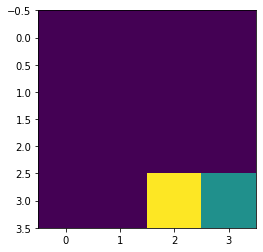

Done!
Episode -  50
Total Rewards -  14741
Performance - Total Rewards/Number of Episodes 294.82


In [6]:
env = GridEnvironment()
state_space = env.observation_space.n
action_space = env.action_space.n
episodes = 50
episode_count = 0;
agent = Agent(state_space, action_space)

total_rewards = 0
final_reward = 0
count = 0

epsilon_arr = list()
performance = list()
done = False
reward = 0 
for e in range(episodes):    
    current_state = env.reset()
    current_state = np.array([current_state])
    
    while (done == False or env.timestep < env.max_timesteps):
        clear_output(wait=True)
        env.render()
        print(reward)
        print(done)
        plt.show()
#         time.sleep(0.001)
        
        action = agent.greedy(current_state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.array([next_state])
    
        agent.replay(current_state, action, reward, next_state, done)
        
        if done:
            agent.epsilon_decay()
            epsilon_arr.append(agent.epsilon_decay())
            break
        current_state = next_state
        total_rewards += reward
        count+=1
        
    if count >= agent.batch_size:
        agent.train()
    episode_count += 1
    final_reward += total_rewards
    performance.append(total_rewards)
    
    print("Done!")
    print("Episode - ", episode_count)

print("Total Rewards - ", final_reward)
print("Performance - Total Rewards/Number of Episodes",(final_reward/episodes))

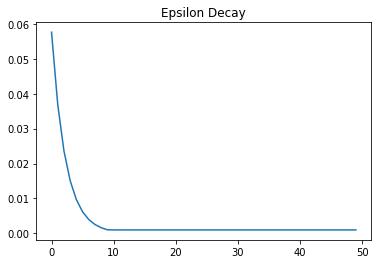

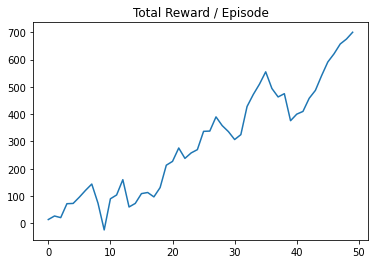

In [7]:
plt.plot(epsilon_arr)
plt.title('Epsilon Decay')
plt.show()

plt.plot(performance) 
plt.title('Total Reward / Episode')
plt.show()

gridDQNgraph = performance

### Double Deep Q-Network

In [8]:
class Agent:
    def __init__(self, state_space, action_space):
        self.action_space = action_space
        self.learning_rate = 0.5
        self.discount_factor = 0.9
        self.epsilon = 0.09
        self.min_epsilon = 0.001
        self.decay = 0.8
        self.batch_size = 128
        self.buffer= list()
        self.max_memory = 5000
        self.epsilon_arr = []
        self.epsilon_arr.append(self.epsilon)
        self.main_model = Sequential([Dense(units=64,input_dim=state_space, activation = 'relu'),
                                 Dense(units=action_space, activation = 'linear')])
        self.main_model.compile(loss="mse", optimizer = Adam(lr=self.learning_rate))
        self.target_model = Sequential([Dense(units=64,input_dim=state_space, activation = 'relu'),
                                 Dense(units=action_space, activation = 'linear')])
        self.target_model.compile(loss="mse", optimizer = Adam(lr=self.learning_rate))
        
        
    def greedy(self, current_state):
        if np.random.random() < self.epsilon:
            return np.argmax(self.main_model.predict(current_state)[0])
        else:
            return np.random.randint(4)

    def epsilon_decay(self):
        self.epsilon = max(self.min_epsilon,(self.epsilon * self.decay))
        return self.epsilon
    
    def update_target_function(self):
        return self.target_model.set_weights(self.main_model.get_weights())
    
    def replay(self, current_state, action, reward, next_state, done):
        self.buffer.append({
            "current_state":current_state,
            "action":action,
            "reward":reward,
            "next_state":next_state,
            "done" :done
        })
        if len(self.buffer) > self.max_memory:
            self.buffer.pop(0)
    

    def train(self):
        np.random.shuffle(self.buffer)
        sample = self.buffer[0:self.batch_size]
        
        for e in sample:
            current_state = self.main_model.predict(e["current_state"])
            next_state = self.target_model.predict(e["next_state"])
            
            reward = e["reward"]
            if not e["done"]:
                reward = reward + self.discount_factor*np.max(self.target_model.predict(e["next_state"])[0])
            current_state[0][e["action"]] = reward
            
        self.main_model.fit(e["current_state"], current_state, verbose=0)

1
False


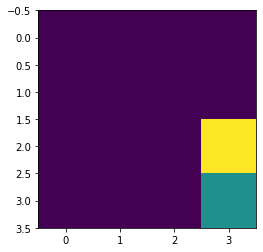

Done!
Episode -  50
Total Rewards -  10208
Performance - Total Rewards/Number of Episodes 204.16


In [9]:
env = GridEnvironment()
state_space = env.observation_space.n
action_space = env.action_space.n
episodes = 50
episode_count = 0;
agent = Agent(state_space, action_space)

total_rewards = 0
final_reward = 0
count = 0
done = False
reward = 0

epsilon_arr = list()
performance = list()

for e in range(episodes):    
    current_state = env.reset()
    current_state = np.array([current_state])
    
    while (done == False or env.timestep < env.max_timesteps):
        clear_output(wait=True)
        env.render()
        print(reward)
        print(done)
        plt.show()
#         time.sleep(0.001)
        
        action = agent.greedy(current_state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.array([next_state])
    
        agent.replay(current_state, action, reward, next_state, done)
        
        if done:
            agent.epsilon_decay()
            epsilon_arr.append(agent.epsilon_decay())
            break
        current_state = next_state
        total_rewards += reward
        count+=1
        
    if count >= agent.batch_size:
        agent.train()
    episode_count += 1
    final_reward += total_rewards
    performance.append(total_rewards)
    
    agent.update_target_function()
    
    print("Done!")
    print("Episode - ", episode_count)

print("Total Rewards - ", final_reward)
print("Performance - Total Rewards/Number of Episodes",(final_reward/episodes))

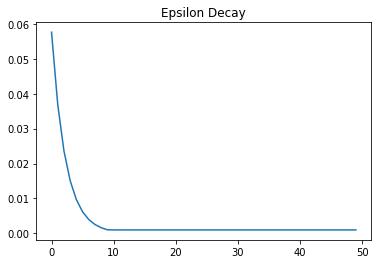

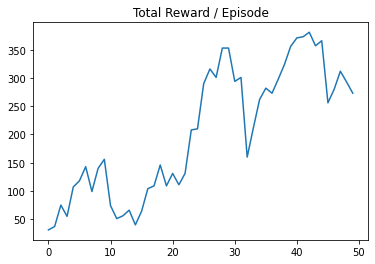

In [10]:
plt.plot(epsilon_arr)
plt.title('Epsilon Decay')
plt.show()

plt.plot(performance) 
plt.title('Total Reward / Episode')
plt.show()

gridDDQNgraph = performance

# Cartpole-v1

In [12]:
!pip install Box2D
import Box2D
from Box2D.b2 import (
    edgeShape,
    circleShape,
    fixtureDef,
    polygonShape,
    revoluteJointDef,
    contactListener,
)

     |████████████████████████████████| 1.3 MB 4.9 MB/s 


### Deep Q-Network

In [13]:
class Agent:
    def __init__(self, state_space, action_space):
        self.action_space = action_space
        self.learning_rate = 0.5
        self.discount_factor = 0.9
        self.epsilon = 0.09
        self.min_epsilon = 0.001
        self.decay = 0.8
        self.batch_size = 128
        self.buffer= list()
        self.max_memory = 5000
        self.epsilon_arr = []
        self.epsilon_arr.append(self.epsilon)
        self.model = Sequential([Dense(units=18,input_dim=state_space, activation = 'relu'),
                                 Dense(units=18,activation = 'relu'),
                                 Dense(units=action_space, activation = 'linear')])
        self.model.compile(loss="mse", optimizer = Adam(lr=self.learning_rate))
        
        
    def greedy(self, current_state):
        if np.random.random() < self.epsilon:
            return np.argmax(self.model.predict(current_state)[0])
        else:
            return np.random.randint(2)

    def epsilon_decay(self):
        self.epsilon = max(self.min_epsilon,(self.epsilon * self.decay))
        return self.epsilon
    
    def replay(self, current_state, action, reward, next_state, done):
        self.buffer.append({
            "current_state":current_state,
            "action":action,
            "reward":reward,
            "next_state":next_state,
            "done" :done
        })
        if len(self.buffer) > self.max_memory:
            self.buffer.pop(0)
    

    def train(self):
        np.random.shuffle(self.buffer)
        sample = self.buffer[0:self.batch_size]

        for e in sample:
            current_state = self.model.predict(e["current_state"])
            reward = e["reward"]
            if not e["done"]:
                reward = reward + self.discount_factor*np.max(self.model.predict(e["next_state"])[0])
            current_state[0][e["action"]] = reward
            self.model.fit(e["current_state"], current_state, verbose=0)

In [14]:
env_1 = gym.make('CartPole-v1')
states = env_1.observation_space.shape[0]
action = env_1.action_space.n

env = env_1
env = env.unwrapped
#env = gym.wrappers.Monitor(env,directory='cartpole-hill/',force=True,write_upon_reset=True)
#state_space = env.observation_space.n
#action_space = env.action_space.n
episodes = 100
episode_count = 0;
agent = Agent(states, action)

total_rewards = 0
final_reward = 0
count = 0

epsilon_arr = list()
performance = list()
done = False
reward = 0 
for e in range(episodes):    
    current_state = env.reset()
    current_state = np.array([current_state])
    
    while (done == False):
        #current_state = env.reset()
        #current_state = np.array([current_state])
        clear_output(wait=True)
        time.sleep(0.01)
        #env.render()
        print(reward)
        print(done)
        plt.show()
        action = agent.greedy(current_state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.array([next_state])
        agent.replay(current_state, action, reward, next_state, done)
        if done:
            agent.epsilon_decay()
            epsilon_arr.append(agent.epsilon_decay())
            break
        current_state = next_state
        total_rewards += reward
        count+=1
        #env.reset()
    if count >= agent.batch_size:
        
        agent.train()
    episode_count += 1
    final_reward += total_rewards
    performance.append(total_rewards)
    
    print("Done!")
    print("Episode - ", episode_count)

print("Total Rewards - ", final_reward)
print("Performance - Total Rewards/Number of Episodes",(final_reward/episodes))

1.0
False
Done!
Episode -  1
Done!
Episode -  2
Done!
Episode -  3
Done!
Episode -  4
Done!
Episode -  5
Done!
Episode -  6
Done!
Episode -  7
Done!
Episode -  8
Done!
Episode -  9
Done!
Episode -  10
Done!
Episode -  11
Done!
Episode -  12
Done!
Episode -  13
Done!
Episode -  14
Done!
Episode -  15
Done!
Episode -  16
Done!
Episode -  17
Done!
Episode -  18
Done!
Episode -  19
Done!
Episode -  20
Done!
Episode -  21
Done!
Episode -  22
Done!
Episode -  23
Done!
Episode -  24
Done!
Episode -  25
Done!
Episode -  26
Done!
Episode -  27
Done!
Episode -  28
Done!
Episode -  29
Done!
Episode -  30
Done!
Episode -  31
Done!
Episode -  32
Done!
Episode -  33
Done!
Episode -  34
Done!
Episode -  35
Done!
Episode -  36
Done!
Episode -  37
Done!
Episode -  38
Done!
Episode -  39
Done!
Episode -  40
Done!
Episode -  41
Done!
Episode -  42
Done!
Episode -  43
Done!
Episode -  44
Done!
Episode -  45
Done!
Episode -  46
Done!
Episode -  47
Done!
Episode -  48
Done!
Episode -  49
Done!
Episode -  50

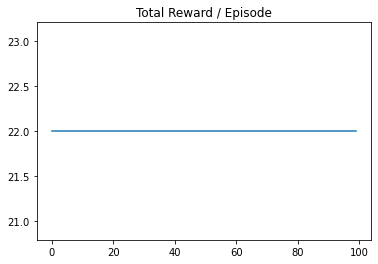

In [15]:
plt.plot(performance) 
plt.title('Total Reward / Episode')
plt.show()

cartpoleDQNgraph = performance

# Acrobat-v0

### Deep Q-Network

In [21]:
class Agent:
    def __init__(self, state_space, action_space):
        self.action_space = action_space
        self.learning_rate = 0.5
        self.discount_factor = 0.9
        self.epsilon = 0.09
        self.min_epsilon = 0.001
        self.decay = 0.8
        self.batch_size = 128
        self.buffer= list()
        self.max_memory = 5000
        self.epsilon_arr = []
        self.epsilon_arr.append(self.epsilon)
        self.model = Sequential([Dense(units=18,input_dim=state_space, activation = 'relu'),
                                 Dense(units=18,activation = 'relu'),
                                 Dense(units=action_space, activation = 'linear')])
        self.model.compile(loss="mse", optimizer = Adam(lr=self.learning_rate))
        
        
    def greedy(self, current_state):
        if np.random.random() < self.epsilon:
            return np.argmax(self.model.predict(current_state)[0])
        else:
            return np.random.randint(2)

    def epsilon_decay(self):
        self.epsilon = max(self.min_epsilon,(self.epsilon * self.decay))
        return self.epsilon
    
    def replay(self, current_state, action, reward, next_state, done):
        self.buffer.append({
            "current_state":current_state,
            "action":action,
            "reward":reward,
            "next_state":next_state,
            "done" :done
        })
        if len(self.buffer) > self.max_memory:
            self.buffer.pop(0)
    

    def train(self):
        np.random.shuffle(self.buffer)
        sample = self.buffer[0:self.batch_size]

        for e in sample:
            current_state = self.model.predict(e["current_state"])
            reward = e["reward"]
            if not e["done"]:
                reward = reward + self.discount_factor*np.max(self.model.predict(e["next_state"])[0])
            current_state[0][e["action"]] = reward
            self.model.fit(e["current_state"], current_state, verbose=0)

In [22]:
env_2 = gym.make('Acrobot-v1')
states = env_2.observation_space.shape[0]
action = env_2.action_space.n

env = env_2
env = env.unwrapped
#env = gym.wrappers.Monitor(env,directory='cartpole-hill/',force=True,write_upon_reset=True)
#state_space = env.observation_space.n
#action_space = env.action_space.n
episodes = 100
episode_count = 0;
agent = Agent(states, action)

total_rewards = 0
final_reward = 0
count = 0

epsilon_arr = list()
performance = list()
done = False
reward = 0 
for e in range(episodes):    
    current_state = env.reset()
    current_state = np.array([current_state])
    
    while (done == False):
        #current_state = env.reset()
        #current_state = np.array([current_state])
        clear_output(wait=True)
        time.sleep(0.01)
        #env.render()
        print(reward)
        print(done)
        plt.show()
        action = agent.greedy(current_state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.array([next_state])
        agent.replay(current_state, action, reward, next_state, done)
        if done:
            agent.epsilon_decay()
            epsilon_arr.append(agent.epsilon_decay())
            break
        current_state = next_state
        total_rewards += reward
        count+=1
        #env.reset()
    if count >= agent.batch_size:
        
        agent.train()
    episode_count += 1
    final_reward += total_rewards
    performance.append(total_rewards)
    
    print("Done!")
    print("Episode - ", episode_count)

print("Total Rewards - ", final_reward)
print("Performance - Total Rewards/Number of Episodes",(final_reward/episodes))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.0
False
-1.

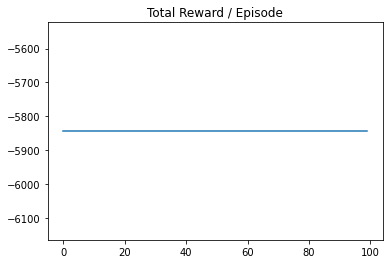

In [23]:
plt.plot(performance) 
plt.title('Total Reward / Episode')
plt.show()

acrobatDQNgraph = performance

### Compare the performance of both algorithms (DQN & Improved version of DQN) on the same environments (e.g. show one graph with two reward dynamics) and provide your interpretation of the results.

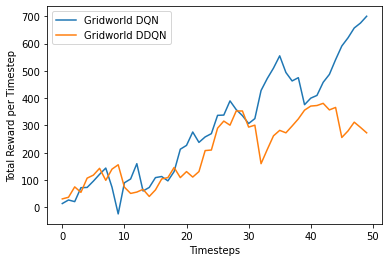

In [26]:
plt.plot(gridDQNgraph, label="Gridworld DQN")
plt.plot(gridDDQNgraph, label="Gridworld DDQN")
plt.xlabel("Timesteps")
plt.ylabel("Total Reward per Timestep")
plt.legend()
plt.show()

###  Provide your interpretation of the results. E.g. how the same algorithm behaves on different environ- ments, or how various algorithms behave on the same environment.

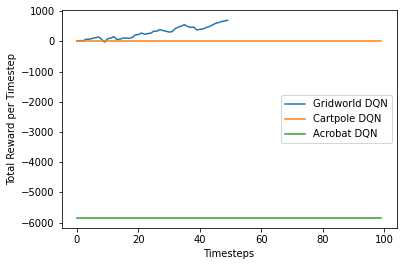

In [27]:
plt.plot(gridDQNgraph, label="Gridworld DQN")
plt.plot(cartpoleDQNgraph, label="Cartpole DQN")
plt.plot(acrobatDQNgraph, label="Acrobat DQN")
plt.xlabel("Timesteps")
plt.ylabel("Total Reward per Timestep")
plt.legend()
plt.show()